# Learn Limonene Dynamics

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tpot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.1 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=6e692138b4a40b3e8d13637c02213ff87cbbdb1fb1b2047fed10fdb20a7cce55
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [3]:
!pip install torchdiffeq

In [4]:
import torch
import numpy as np
import matplotlib
import torchdiffeq

print(f"PyTorch: {torch.__version__}")
print(f"torchdiffeq: {torchdiffeq.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")

PyTorch: 2.5.1+cu121
torchdiffeq: 0.2.5
NumPy: 1.26.4
Matplotlib: 3.8.0


In [5]:
import os
os.chdir("/content/drive/MyDrive/KineticLearning/notebooks")

In [6]:
from KineticLearning import learn_dynamics, read_timeseries_data, simulate_dynamics
from IPython.display import display
import pandas as pd
import time
import pickle

In [7]:
# CPU info
!cat /proc/cpuinfo | grep 'model name' | uniq
!cat /proc/cpuinfo | grep 'cpu cores' | uniq

# RAM
!free -h

# GPU info
!nvidia-smi

# Python and system version
import sys
import platform
print("\nPython version:", sys.version)
print("OS version:", platform.platform())

# Number of CPU cores
import multiprocessing
print("\nCPU cores:", multiprocessing.cpu_count())

# Detailed GPU info
import torch
if torch.cuda.is_available():
    print("\nGPU name:", torch.cuda.get_device_name(0))
    print("GPU memory:", torch.cuda.get_device_properties(0).total_memory / 1024**3, "GB")

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
cpu cores	: 4
               total        used        free      shared  buff/cache   available
Mem:            50Gi       1.6Gi        45Gi       1.0Mi       4.2Gi        48Gi
Swap:             0B          0B          0B
Mon Dec  9 08:04:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |       

In [68]:
columns = pd.read_csv("/content/drive/MyDrive/KineticLearning/data/limonene_data.csv").columns


# List of proteins (controls)
controls_list = [
    "AtoB", "GPPS", "HMGR", "HMGS", "Idi",
    "Limonene Synthase", "MK", "NudB", "PMD", "PMK"
]

# Separate into controls and states
controls = [column for column in columns if column in controls_list]
# remove strain, and hour columns
states = [column for column in columns if column not in controls][2:]

# Print the results
print("Controls:", controls)
print("States:", states)


limonene_df = read_timeseries_data('/content/drive/MyDrive/KineticLearning/data/limonene_data.csv',states,controls,time='Hour',strain='Strain',augment=200)

Controls: ['AtoB', 'GPPS', 'HMGR', 'HMGS', 'Idi', 'Limonene Synthase', 'MK', 'NudB', 'PMD', 'PMK']
States: ['Acetyl-CoA', 'HMG-CoA', 'Mevalonate', 'Mev-P', 'IPP/DMAPP', 'Limonene', 'OD600', 'GPP', 'NAD', 'NADP', 'Acetate', 'Pyruvate', 'citrate', 'Isopentenol']


In [69]:
limonene_df['controls']

AtoB          GPPS           HMGR  \
Strain Strain Time                                                    
L1     L1     0.000000     4104.500000  3.967000e+03   17116.000000   
              0.361809    65615.416667  5.693971e+04   20349.083333   
              0.723618   127126.333333  1.099124e+05   23582.166667   
              1.085427   188637.250000  1.628851e+05   26815.250000   
              1.447236   250148.166667  2.158578e+05   30048.333333   
...                                ...           ...            ...   
L3     L3     70.552764  829542.649254  1.438315e+06  103534.250000   
              70.914573  828553.111940  1.436474e+06  103345.000000   
              71.276382  827563.574627  1.434632e+06  103155.750000   
              71.638191  826574.037313  1.432790e+06  102966.500000   
              72.000000  825584.500000  1.430948e+06  102777.250000   

                                  HMGS           Idi  Limonene Synthase  \
Strain Strain Time                                                        
L1     L1     0.000000     7309.500000  3.393615e+05       1.165400e+05   
              0.361809    16969.729167  3.478612e+05       6.978500e+05   
              0.723618    26629.958333  3.563608e+05       1.279160e+06   
              1.085427    36290.187500  3.648605e+05       1.860470e+06   
              1.447236    45950.416667  3.733602e+05       2.441780e+06   
...                                ...           ...                ...   
L3     L3     70.552764  246838.697761  1.889937e+06       7.830364e+06   
              70.914573  246446.585821  1.886034e+06       7.823062e+06   
              71.276382  246054.473881  1.882131e+06       7.815760e+06   
              71.638191  245662.361940  1.878228e+06       7.808457e+06   
              72.000000  245270.250000  1.874325e+06       7.801155e+06   

                                    MK          NudB           PMD  \
Strain Strain Time                                                   
L1     L1     0.000000     9766.000000   5413.500000  1.746315e+05   
              0.361809    11037.041667   6972.125000  1.832929e+05   
              0.723618    12308.083333   8530.750000  1.919542e+05   
              1.085427    13579.125000  10089.375000  2.006156e+05   
              1.447236    14850.166667  11648.000000  2.092770e+05   
...                                ...           ...           ...   
L3     L3     70.552764  967101.835821  17465.358209  2.395696e+06   
              70.914573  965239.626866  17396.268657  2.394607e+06   
              71.276382  963377.417910  17327.179104  2.393519e+06   
              71.638191  961515.208955  17258.089552  2.392430e+06   
              72.000000  959653.000000  17189.000000  2.391342e+06   

                                   PMK  
Strain Strain Time                      
L1     L1     0.000000    39064.500000  
              0.361809    37143.458333  
              0.723618    35222.416667  
              1.085427    33301.375000  
              1.447236    31380.333333  
...                                ...  
L3     L3     70.552764  622514.380597  
              70.914573  621213.410448  
              71.276382  619912.440299  
              71.638191  618611.470149  
              72.000000  617310.500000  

[600 rows x 10 columns]

In [70]:
# drop any columns that have no values at all. In other cases, the values will be imputed when generating the new 200 length time series
limonene_df = limonene_df.dropna(axis=1, how='all')

In [71]:
limonene_df.columns

MultiIndex([(     'states',        'Acetyl-CoA'),
            (     'states',           'HMG-CoA'),
            (     'states',        'Mevalonate'),
            (     'states',             'Mev-P'),
            (     'states',         'IPP/DMAPP'),
            (     'states',          'Limonene'),
            (     'states',             'OD600'),
            (     'states',               'GPP'),
            (     'states',               'NAD'),
            (     'states',              'NADP'),
            (     'states',           'Acetate'),
            (     'states',          'Pyruvate'),
            (     'states',           'citrate'),
            (   'controls',              'AtoB'),
            (   'controls',              'GPPS'),
            (   'controls',              'HMGR'),
            (   'controls',              'HMGS'),
            (   'controls',               'Idi'),
            (   'controls', 'Limonene Synthase'),
            (   'controls',                'MK'),


In [72]:
# drop duplicated indices
limonene_df.index = limonene_df.index.droplevel(0)

## Baseline

In [13]:
lim_start_time_learn_baseline = time.time()
# train on two strains
model = learn_dynamics(limonene_df.loc[['L1','L3']],generations=12,population_size=30,verbose=True)
lim_end_time_learn_baseline = time.time()
lim_time_to_learn_baseline = lim_end_time_learn_baseline - lim_start_time_learn_baseline
print(f"baseline train time : {lim_time_to_learn_baseline}")

# Save training time to a file
with open("baseline_limonene_training_times.txt", "w") as f:
    f.write(f"Baseline training time: {lim_time_to_learn_baseline} seconds\n")

Fitting model for derivative 'Acetyl-CoA': X shape (400, 23), y shape (400,)


Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.00032553545962820903

Generation 2 - Current best internal CV score: -0.00032553545962820903

Generation 3 - Current best internal CV score: -0.00032537890879910235

Generation 4 - Current best internal CV score: -0.0003109521543079931

Generation 5 - Current best internal CV score: -0.0003109521543079931

Generation 6 - Current best internal CV score: -0.0003109521543079931

Generation 7 - Current best internal CV score: -0.0003109521543079931

Generation 8 - Current best internal CV score: -0.0003109521543079931

Generation 9 - Current best internal CV score: -0.0003109521543079931

Generation 10 - Current best internal CV score: -0.0003109521543079931

Generation 11 - Current best internal CV score: -0.0002926966598911868

Generation 12 - Current best internal CV score: -0.0002926966598911868

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.8, min_samples_leaf=13, min_samples_split=14, n_estimators

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -6.608932129328212e-05

Generation 2 - Current best internal CV score: -6.608932129328212e-05

Generation 3 - Current best internal CV score: -6.608932129328212e-05

Generation 4 - Current best internal CV score: -6.608932129328212e-05

Generation 5 - Current best internal CV score: -6.608932129328212e-05

Generation 6 - Current best internal CV score: -6.608932129328212e-05

Generation 7 - Current best internal CV score: -6.608932129328212e-05

Generation 8 - Current best internal CV score: -6.608932129328212e-05

Generation 9 - Current best internal CV score: -6.608932129328212e-05

Generation 10 - Current best internal CV score: -6.608932129328212e-05

Generation 11 - Current best internal CV score: -6.608932129328212e-05

Generation 12 - Current best internal CV score: -6.608932129328212e-05

Best pipeline: LinearSVR(input_matrix, C=15.0, dual=True, epsilon=0.1, loss=squared_epsilon_insensitive, tol=0.001)
Best pipeline for 'HMG-CoA':

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.0009558895827561987

Generation 2 - Current best internal CV score: -0.0009558895827561987

Generation 3 - Current best internal CV score: -0.0009558895827561987

Generation 4 - Current best internal CV score: -0.0009486119052502442

Generation 5 - Current best internal CV score: -0.0009414159929289668

Generation 6 - Current best internal CV score: -0.0009414159929289668

Generation 7 - Current best internal CV score: -0.0009414159929289668

Generation 8 - Current best internal CV score: -0.000935340254693201

Generation 9 - Current best internal CV score: -0.000935340254693201

Generation 10 - Current best internal CV score: -0.000935340254693201

Generation 11 - Current best internal CV score: -0.0009335429142028286

Generation 12 - Current best internal CV score: -0.0009335429142028286

Best pipeline: XGBRegressor(ElasticNetCV(input_matrix, l1_ratio=0.4, tol=0.0001), learning_rate=0.01, max_depth=9, min_child_weight=19, n_estimator

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.023750493725639674

Generation 2 - Current best internal CV score: -0.021752953420978962

Generation 3 - Current best internal CV score: -0.021752953420978962

Generation 4 - Current best internal CV score: -0.021752953420978962

Generation 5 - Current best internal CV score: -0.021752953420978962

Generation 6 - Current best internal CV score: -0.021752953420978962

Generation 7 - Current best internal CV score: -0.020995082707478633

Generation 8 - Current best internal CV score: -0.020995082707478633

Generation 9 - Current best internal CV score: -0.020995082707478633

Generation 10 - Current best internal CV score: -0.020995082707478633

Generation 11 - Current best internal CV score: -0.020995082707478633

Generation 12 - Current best internal CV score: -0.020995082707478633

Best pipeline: ExtraTreesRegressor(Normalizer(StandardScaler(input_matrix), norm=max), bootstrap=False, max_features=0.15000000000000002, min_samples_leaf=3

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.10404754165600696

Generation 2 - Current best internal CV score: -0.10392019636106464

Generation 3 - Current best internal CV score: -0.10096625258402239

Generation 4 - Current best internal CV score: -0.10096625258402239

Generation 5 - Current best internal CV score: -0.10096625258402239

Generation 6 - Current best internal CV score: -0.09952030452813423

Generation 7 - Current best internal CV score: -0.09952030452813423

Generation 8 - Current best internal CV score: -0.09952030452813423

Generation 9 - Current best internal CV score: -0.09952030452813423

Generation 10 - Current best internal CV score: -0.09864620845653733

Generation 11 - Current best internal CV score: -0.09864620845653733

Generation 12 - Current best internal CV score: -0.09864620845653733

Best pipeline: ExtraTreesRegressor(XGBRegressor(input_matrix, learning_rate=0.001, max_depth=4, min_child_weight=7, n_estimators=100, n_jobs=1, objective=reg:squarederr

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -9.943034130327065e-06

Generation 2 - Current best internal CV score: -9.078466131666227e-06

Generation 3 - Current best internal CV score: -8.883841582438567e-06

Generation 4 - Current best internal CV score: -8.387675028848105e-06

Generation 5 - Current best internal CV score: -6.911602023124458e-06

Generation 6 - Current best internal CV score: -6.911602023124458e-06

Generation 7 - Current best internal CV score: -6.911602023124458e-06

Generation 8 - Current best internal CV score: -5.8909535761524254e-06

Generation 9 - Current best internal CV score: -5.8909535761524254e-06

Generation 10 - Current best internal CV score: -5.8909535761524254e-06

Generation 11 - Current best internal CV score: -5.8909535761524254e-06

Generation 12 - Current best internal CV score: -5.8909535761524254e-06

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=3, min_samples_split=6,

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.0015484970836360655

Generation 2 - Current best internal CV score: -0.0015484970836360655

Generation 3 - Current best internal CV score: -0.0014570672516780174

Generation 4 - Current best internal CV score: -0.001357764950842557

Generation 5 - Current best internal CV score: -0.0011052664334192737

Generation 6 - Current best internal CV score: -0.0011052664334192737

Generation 7 - Current best internal CV score: -0.0011052664334192737

Generation 8 - Current best internal CV score: -0.0011052664334192737

Generation 9 - Current best internal CV score: -0.0010887570419995207

Generation 10 - Current best internal CV score: -0.0010887570419995207

Generation 11 - Current best internal CV score: -0.0010887570419995207

Generation 12 - Current best internal CV score: -0.0010887570419995207

Best pipeline: AdaBoostRegressor(GradientBoostingRegressor(input_matrix, alpha=0.85, learning_rate=0.001, loss=huber, max_depth=9, max_features=0

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2.1217224537623836e-05

Generation 2 - Current best internal CV score: -2.1217224537623836e-05

Generation 3 - Current best internal CV score: -2.1217224537623836e-05

Generation 4 - Current best internal CV score: -2.1217224537623836e-05

Generation 5 - Current best internal CV score: -2.1217224537623836e-05

Generation 6 - Current best internal CV score: -2.1217224537623836e-05

Generation 7 - Current best internal CV score: -2.1217224537623836e-05

Generation 8 - Current best internal CV score: -2.1217224537623836e-05

Generation 9 - Current best internal CV score: -2.1217224537623836e-05

Generation 10 - Current best internal CV score: -2.1217224537623836e-05

Generation 11 - Current best internal CV score: -2.1217224537623836e-05

Generation 12 - Current best internal CV score: -2.1217224537623836e-05

Best pipeline: SGDRegressor(input_matrix, alpha=0.0, eta0=0.1, fit_intercept=True, l1_ratio=0.25, learning_rate=constant, loss=epsil

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.0029092142664335534

Generation 2 - Current best internal CV score: -0.002702204480508021

Generation 3 - Current best internal CV score: -0.002702204480508021

Generation 4 - Current best internal CV score: -0.002702204480508021

Generation 5 - Current best internal CV score: -0.0018110164036768412

Generation 6 - Current best internal CV score: -0.0018110164036768412

Generation 7 - Current best internal CV score: -0.0018110164036768412

Generation 8 - Current best internal CV score: -0.0018110164036768412

Generation 9 - Current best internal CV score: -0.0018110164036768412

Generation 10 - Current best internal CV score: -0.0018110164036768412

Generation 11 - Current best internal CV score: -0.0018110164036768412

Generation 12 - Current best internal CV score: -0.0018110164036768412

Best pipeline: XGBRegressor(ExtraTreesRegressor(StandardScaler(MinMaxScaler(input_matrix)), bootstrap=False, max_features=0.8, min_samples_leaf=7, 

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2.4474218398289104e-05

Generation 2 - Current best internal CV score: -2.4443219950818954e-05

Generation 3 - Current best internal CV score: -2.299421500618477e-05

Generation 4 - Current best internal CV score: -2.2566823480749092e-05

Generation 5 - Current best internal CV score: -2.2566823480749092e-05

Generation 6 - Current best internal CV score: -2.207641116112193e-05

Generation 7 - Current best internal CV score: -2.207641116112193e-05

Generation 8 - Current best internal CV score: -2.129216843358548e-05

Generation 9 - Current best internal CV score: -2.129216843358548e-05

Generation 10 - Current best internal CV score: -2.129216843358548e-05

Generation 11 - Current best internal CV score: -2.129216843358548e-05

Generation 12 - Current best internal CV score: -2.1073359698302315e-05

Best pipeline: ExtraTreesRegressor(ElasticNetCV(input_matrix, l1_ratio=0.05, tol=0.01), bootstrap=True, max_features=0.9500000000000001, mi

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.0006847169606943857

Generation 2 - Current best internal CV score: -0.0006847169606943857

Generation 3 - Current best internal CV score: -0.0004935030870792629

Generation 4 - Current best internal CV score: -0.0004935030870792629

Generation 5 - Current best internal CV score: -0.0004935030870792629

Generation 6 - Current best internal CV score: -0.0004935030870792629

Generation 7 - Current best internal CV score: -0.0004935030870792629

Generation 8 - Current best internal CV score: -0.0004935030870792629

Generation 9 - Current best internal CV score: -0.0004935030870792629

Generation 10 - Current best internal CV score: -0.0004935030870792629

Generation 11 - Current best internal CV score: -0.0004935030870792629

Generation 12 - Current best internal CV score: -0.0004930771619651445

Best pipeline: ExtraTreesRegressor(StandardScaler(input_matrix), bootstrap=False, max_features=0.25, min_samples_leaf=1, min_samples_split=11, n

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.0010784763998478637

Generation 2 - Current best internal CV score: -0.0010784763998478637

Generation 3 - Current best internal CV score: -0.0010762995621430185

Generation 4 - Current best internal CV score: -0.0010762995621430185

Generation 5 - Current best internal CV score: -0.0010762995621430185

Generation 6 - Current best internal CV score: -0.0010762995621430185

Generation 7 - Current best internal CV score: -0.0010762995621430185

Generation 8 - Current best internal CV score: -0.0010759021387623598

Generation 9 - Current best internal CV score: -0.0010758895852013455

Generation 10 - Current best internal CV score: -0.0010739245407372848

Generation 11 - Current best internal CV score: -0.0010684475142186307

Generation 12 - Current best internal CV score: -0.001067631928251917

Best pipeline: XGBRegressor(DecisionTreeRegressor(input_matrix, max_depth=5, min_samples_leaf=3, min_samples_split=2), learning_rate=0.01, max_de

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1.9630458072339453e-05

Generation 2 - Current best internal CV score: -1.9126741229230978e-05

Generation 3 - Current best internal CV score: -1.9126741229230978e-05

Generation 4 - Current best internal CV score: -1.891709452681746e-05

Generation 5 - Current best internal CV score: -1.8739354426220053e-05

Generation 6 - Current best internal CV score: -1.8554974374231702e-05

Generation 7 - Current best internal CV score: -1.8554974374231702e-05

Generation 8 - Current best internal CV score: -1.8554974374231702e-05

Generation 9 - Current best internal CV score: -1.8554974374231702e-05

Generation 10 - Current best internal CV score: -1.8554974374231702e-05

Generation 11 - Current best internal CV score: -1.8554974374231702e-05

Generation 12 - Current best internal CV score: -1.7984398024050838e-05

Best pipeline: KNeighborsRegressor(MinMaxScaler(RidgeCV(input_matrix)), n_neighbors=12, p=2, weights=distance)
Best pipeline for 'cit

,model
Acetyl-CoA,"((DecisionTreeRegressor(max_features=0.8, min_..."
HMG-CoA,"(LinearSVR(C=15.0, dual=True, epsilon=0.1, los..."
Mevalonate,(StackingEstimator(estimator=ElasticNetCV(l1_r...
Mev-P,"(StandardScaler(), Normalizer(norm='max'), (Ex..."
IPP/DMAPP,(StackingEstimator(estimator=XGBRegressor(base...
Limonene,((ExtraTreeRegressor(max_features=0.7500000000...
OD600,(StackingEstimator(estimator=GradientBoostingR...
GPP,"(SGDRegressor(alpha=0.0, eta0=0.1, l1_ratio=0...."
NAD,"(MinMaxScaler(), StandardScaler(), StackingEst..."
NADP,(StackingEstimator(estimator=ElasticNetCV(l1_r...


baseline train time : 3124.527866125107


In [ ]:
# # Save the trained model to disk
# with open("lim_baseline_trained_model.pkl", "wb") as model_file:
#     pickle.dump(model, model_file)
# print("Model saved to 'lim_baseline_trained_model.pkl'.")

In [28]:
# Test on unseen strain
strain_df = limonene_df.loc['L2']

lim_start_time_to_predict_from_baseline = time.time()
trajectory_df = simulate_dynamics(model,strain_df,verbose=True)
lim_end_time_to_predict_from_baseline = time.time()
lim_time_baseline_predict = lim_end_time_to_predict_from_baseline - lim_start_time_to_predict_from_baseline
print(f"Baseline predict time : {lim_time_baseline_predict}")

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/KineticLearning/notebooks/KineticLearning.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = self.model_df.apply(lambda model: model[0].predict(X.reshape(1,-1)),axis=1).values.reshape(-1,)
/content/drive/MyDrive/KineticLearning/notebooks/KineticLearning.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = self.model_df.apply(lambda model: model[0].predict(X.reshape(1,-1)),axis=1).values.reshape(-1,)
/content/drive/MyDrive/KineticLearning/notebooks/KineticLearning.py:260: FutureWarning: Series.__getitem__ treating keys as positions i

Baseline predict time : 290.6886260509491


/content/drive/MyDrive/KineticLearning/notebooks/KineticLearning.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = self.model_df.apply(lambda model: model[0].predict(X.reshape(1,-1)),axis=1).values.reshape(-1,)
/content/drive/MyDrive/KineticLearning/notebooks/KineticLearning.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = self.model_df.apply(lambda model: model[0].predict(X.reshape(1,-1)),axis=1).values.reshape(-1,)
/content/drive/MyDrive/KineticLearning/notebooks/KineticLearning.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

In [29]:
lim_time_baseline_predict

290.6886260509491

In [30]:
# Append prediction time to the file
with open("limonene_training_times.txt", "a") as f:
    f.write(f"Baseline prediction time: {lim_time_baseline_predict} seconds\n")

In [ ]:
# Save trajectory_df to disk as a CSV file
trajectory_df.to_csv("lim_baseline_trajectory_df.csv", index=False)
print("Trajectory data saved to 'trajectory_df.csv'.")

In [ ]:
# load trajectory
trajectory_df = pd.read_csv("lim_baseline_trajectory_df.csv")

## NODE model

In [62]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torchdiffeq import odeint
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim import LBFGS
# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
limonene_df.loc['L1'][["states","controls"]].values.shape
times = limonene_df.loc['L1'].index.values.reshape(-1,1)

In [64]:
limonene_df.loc[['L1','L3']][["states","controls"]]['states']

Acetyl-CoA   HMG-CoA  Mevalonate     Mev-P  IPP/DMAPP  \
Strain Time                                                               
L1     0.000000     0.386459  0.002562    0.003715  0.000000   0.071364   
       0.361809     0.422194  0.019279    0.016853  0.043058   0.125500   
       0.723618     0.457928  0.035995    0.029991  0.086115   0.179637   
       1.085427     0.493663  0.052711    0.043128  0.129173   0.233774   
       1.447236     0.529398  0.069427    0.056266  0.172230   0.287910   
...                      ...       ...         ...       ...        ...   
L3     70.552764    0.163314  0.000000    1.360567  9.217660  10.778166   
       70.914573    0.163314  0.000000    1.362904  9.271697  10.801382   
       71.276382    0.163314  0.000000    1.365241  9.325734  10.824598   
       71.638191    0.163314  0.000000    1.367578  9.379772  10.847814   
       72.000000    0.163314  0.000000    1.369915  9.433809  10.871030   

                  Limonene     OD600       GPP       NAD      NADP   Acetate  \
Strain Time                                                                    
L1     0.000000   0.000000  1.325506  0.008239  0.641765  0.076970  0.496416   
       0.361809   0.000201  1.462298  0.011835  0.793468  0.086237  0.591430   
       0.723618   0.000403  1.599089  0.015431  0.945171  0.095505  0.686444   
       1.085427   0.000604  1.735880  0.019027  1.096874  0.104772  0.781458   
       1.447236   0.000806  1.872671  0.022623  1.248577  0.114039  0.876472   
...                    ...       ...       ...       ...       ...       ...   
L3     70.552764  0.498310  3.624030  0.000000  1.721404  0.282933  1.650343   
       70.914573  0.499699  3.625522  0.000000  1.721404  0.282933  1.652800   
       71.276382  0.501088  3.627015  0.000000  1.721404  0.282933  1.655257   
       71.638191  0.502477  3.628507  0.000000  1.721404  0.282933  1.657713   
       72.000000  0.503867  3.630000  0.000000  1.721404  0.282933  1.660170   

                  Pyruvate   citrate  
Strain Time                           
L1     0.000000   0.114881  0.042705  
       0.361809   0.113232  0.049954  
       0.723618   0.111583  0.057203  
       1.085427   0.109935  0.064453  
       1.447236   0.108286  0.071702  
...                    ...       ...  
L3     70.552764  0.000393  0.059404  
       70.914573  0.000399  0.059404  
       71.276382  0.000405  0.059404  
       71.638191  0.000412  0.059404  
       72.000000  0.000418  0.059404  

[400 rows x 13 columns]

In [65]:
# Single strain
#inputs = limonene_df.loc['L1'][["states","controls"]].values
# 2 strains
inputs = limonene_df.loc[['L1','L3']][["states","controls"]].values
# Prepare dataset
X_train = torch.Tensor(inputs).to(device)  # Input data: shape (n_points, 2)
y_train = torch.Tensor(inputs).to(device) # Target data: shape (n_points, 1)

# Create TensorDataset and DataLoader
train_dataset = data.TensorDataset(X_train, y_train)
train_loader = data.DataLoader(train_dataset, batch_size=len(inputs)//2, shuffle=False)

In [66]:
class NeuralODEFunc(nn.Module):
    def __init__(self):
        super(NeuralODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(23, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10,10),
            nn.Tanh(),
            nn.Linear(10, 23)  # Output same size as input features
        )

        # initialize weights
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
        return self.net(x)  # Return the time derivative dx/dt

class NeuralODE(nn.Module):
    def __init__(self, func, t_span):
        super(NeuralODE, self).__init__()
        self.func = func
        self.t_span = t_span

    def forward(self, x):
        # Solve the ODE for the given input x
        #print(x[0].shape)
        # NOTE -- Error propagates massively if you predict from x[t=0] --> x[t_n ]
        # and try to train on that
        out = odeint(self.func, x, self.t_span, method='dopri8')
        #print(out.shape)
        return out[-1]  # Return the final state at the last time point

    def all_trajectores(self,x):
        out = odeint(self.func, x, self.t_span, method='dopri8')
        #print(out.shape)
        return out  # Return the final state at the last time point

    def predict(self,x):
        out = odeint(self.func,x[0],self.t_span, method='dopri8')
        #print(out.shape)
        return out

In [36]:
# Define time span for solving the ODE
t_span = torch.linspace(0, 72, 200).to(device) # Time span for integration
# Define loss function and optimizer
criterion = nn.MSELoss()
pen_loss = lambda x : min(0.0,x)
pen_loss = np.vectorize(pen_loss)
training_times = {}
# Training loop
epochs = 300
penalty_weights = [0.01,1,1e3]
for penalty_weight in penalty_weights:
    # Instantiate the ODE function and model
    func = NeuralODEFunc()
    model = NeuralODE(func, t_span).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    lim_start_time_NODE_training = time.time()
    print("##############")
    print(f"Training with penalty {penalty_weight}")
    print("Starting ADAM...")
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            y_pred = model(batch_X)  # Predict y using the Neural ODE
            #l += λ .* sum(abs2, min.(0, ŷ_reg))
            #print(f"y_pred : {y_pred.shape}, y : {batch_y.shape}")
            loss = criterion(y_pred, batch_y)  # Compute loss
            # penalize the model for predicting values that are negative
            loss_neg = pen_loss(y_pred.detach().cpu().numpy())
            #print(loss.shape)
            loss += penalty_weight*np.mean(np.square(loss_neg))
            #print(y_pred.shape)
            #loss += sum(min(0,))
            loss.backward()
            optimizer.step()
        #if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    # Stage 2: BFGS optimization
    def closure():
        bfgs_optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss_neg = pen_loss(y_pred.cpu().detach().numpy())
        loss += penalty_weight * np.mean(np.square(loss_neg))
        loss.backward()
        print(f"Loss: {loss.item():.4f}")
        return loss
    print("--------------")
    print("Starting BFGS optimization..")
    bfgs_optimizer = LBFGS(model.parameters(), lr=1e-4, max_iter=1000, tolerance_grad=1e-6, tolerance_change=1e-6)
    for batch_X, batch_y in train_loader:
        bfgs_optimizer.step(closure)

    lim_end_time_NODE_training = time.time()
    lim_time_to_learn_NODE = lim_end_time_NODE_training - lim_start_time_NODE_training
    training_times[penalty_weight] = lim_time_to_learn_NODE
    print("BFGS optimization completed.")
    # Save the trained model
    model_path = f"{penalty_weight}_lim_trained_neural_ode_model.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to '{model_path}'.")

##############
Training with penalty 0.01
Starting ADAM...
Epoch 1, Loss: 3.1936
Epoch 2, Loss: 2.9346
Epoch 3, Loss: 4.1797
Epoch 4, Loss: 3.1143
Epoch 5, Loss: 2.3093
Epoch 6, Loss: 2.3182
Epoch 7, Loss: 2.2909
Epoch 8, Loss: 1.9432
Epoch 9, Loss: 1.8529
Epoch 10, Loss: 1.7280
Epoch 11, Loss: 1.6101
Epoch 12, Loss: 1.4827
Epoch 13, Loss: 1.4439
Epoch 14, Loss: 1.4631
Epoch 15, Loss: 1.3537
Epoch 16, Loss: 1.7197
Epoch 17, Loss: 2.0962
Epoch 18, Loss: 1.0362
Epoch 19, Loss: 0.9631
Epoch 20, Loss: 0.9156
Epoch 21, Loss: 0.8757
Epoch 22, Loss: 0.7914
Epoch 23, Loss: 0.7094
Epoch 24, Loss: 0.6667
Epoch 25, Loss: 0.6245
Epoch 26, Loss: 0.5975
Epoch 27, Loss: 0.9818
Epoch 28, Loss: 0.4745
Epoch 29, Loss: 0.5197
Epoch 30, Loss: 1.7681
Epoch 31, Loss: 0.4329
Epoch 32, Loss: 0.4230
Epoch 33, Loss: 0.3829
Epoch 34, Loss: 1.9105
Epoch 35, Loss: 0.3312
Epoch 36, Loss: 2.0110
Epoch 37, Loss: 0.3113
Epoch 38, Loss: 0.3032
Epoch 39, Loss: 0.3398
Epoch 40, Loss: 0.2691
Epoch 41, Loss: 0.3000
Epoch 4

In [37]:
training_times

{0.01: 326.0271122455597, 1: 372.9382755756378, 1000.0: 310.5264880657196}

In [74]:
metabolites = list(limonene_df['states'].columns)
# load the iso_baseline_trajectory_df.csv
trajectory_df = pd.read_csv("lim_baseline_trajectory_df.csv")

In [75]:
trajectory_df

,Acetyl-CoA,HMG-CoA,Mevalonate,Mev-P,IPP/DMAPP,Limonene,OD600,GPP,NAD,NADP,Acetate,Pyruvate,citrate,Time
0,0.286359,0.007628,0.892763,0.046703,0.173321,0.000000,0.713000,0.008239,0.542593,0.081442,0.308866,0.039607,0.021561,0.000000
1,0.304574,0.007628,0.976886,0.104532,0.550581,0.001505,0.827828,0.008239,0.683404,0.093830,0.360224,0.036509,0.022805,0.361809
2,0.315698,0.007628,1.055759,0.160879,1.149511,0.003240,0.942567,0.008239,0.824216,0.105295,0.411979,0.033343,0.023899,0.723618
3,0.314159,0.007628,1.133937,0.200949,1.768404,0.005248,1.057306,0.008239,0.965027,0.115796,0.462489,0.030089,0.025040,1.085427
4,0.312722,0.007628,1.209109,0.233932,2.338746,0.007345,1.172046,0.008239,1.105838,0.125327,0.510553,0.026835,0.026135,1.447236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.557242,0.007628,7.246551,6.771173,129.142904,0.564935,11.669524,0.008239,2.375537,-2.220169,3.395896,-0.185072,-0.010536,70.552764
196,-0.561025,0.007628,7.269394,6.810543,129.804771,0.567499,11.718879,0.008239,2.370445,-2.238089,3.409779,-0.186019,-0.010710,70.914573
197,-0.564808,0.007628,7.292237,6.849913,130.466639,0.570050,11.768234,0.008239,2.365353,-2.256038,3.423634,-0.186966,-0.010883,71.276382
198,-0.568591,0.007628,7.315096,6.889283,131.128507,0.572602,11.817589,0.008239,2.360260,-2.274016,3.437490,-0.187913,-0.011043,71.638191


In [76]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_model(model_path, L2, metabolites, device):
    # Initialize and load model
    func = NeuralODEFunc()
    t_span = torch.linspace(0, 72, 200).to(device)
    model = NeuralODE(func, t_span).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Make predictions
    with torch.no_grad():
        y_pred = model(L2.to(device))
        y_pred = y_pred.cpu().numpy()

    # Calculate RMSE for each metabolite
    rmse_scores = {}
    for i, metabolite in enumerate(metabolites):
        rmse = np.sqrt(mean_squared_error(L2[:, i].cpu().numpy(), y_pred[:, i]))
        rmse_scores[metabolite] = rmse

    return rmse_scores

# Model paths
model_paths = [
    "0.01_lim_trained_neural_ode_model.pth",
    "1_lim_trained_neural_ode_model.pth",
    "1000.0_lim_trained_neural_ode_model.pth"
]

# Test data
L2 = torch.Tensor(limonene_df.loc['L2'][["states","controls"]].values)
metabolites = list(limonene_df['states'].columns)

# Evaluate all models
results = {}
for model_path in model_paths:
    model_name = model_path.split('_')[0]  # Extract the parameter value
    start = time.time()
    results[model_name] = evaluate_model(model_path, L2, metabolites, device)
    end = time.time()
    print(f"eval time : {model_name}, {end-start}")

# Calculate RMSE for baseline using trajectory_df
baseline_rmse = {}
for metabolite in metabolites:
    baseline_values = trajectory_df[metabolite].values
    true_values = L2[:, metabolites.index(metabolite)].cpu().numpy()
    rmse = np.sqrt(mean_squared_error(true_values, baseline_values))
    baseline_rmse[metabolite] = rmse

# Add baseline to results
results['baseline'] = baseline_rmse

# Create DataFrame
results_df = pd.DataFrame(results).round(4)

# Add mean RMSE row
results_df.loc['Mean RMSE'] = results_df.mean()

# Sort columns for better comparison (keeping baseline as last column)
model_cols = sorted([col for col in results_df.columns if col != 'baseline'])
results_df = results_df[model_cols + ['baseline']]

print("Model Comparison - RMSE values:")
print(results_df)

# Save results to CSV
results_df.to_csv('model_comparison_results.csv')

# Also calculate the percentage improvement over baseline
for col in model_cols:
    results_df[f'{col}_vs_baseline'] = ((results_df['baseline'] - results_df[col]) / results_df['baseline'] * 100).round(2)

print("\nPercentage improvement over baseline (%):")
print(results_df[[col for col in results_df.columns if '_vs_baseline' in col]])

<ipython-input-76-7d99f595e750>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


eval time : 0.01, 0.2512810230255127


<ipython-input-76-7d99f595e750>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


eval time : 1, 0.294464111328125


<ipython-input-76-7d99f595e750>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


eval time : 1000.0, 0.2252802848815918
Model Comparison - RMSE values:
                0.01         1    1000.0   baseline
Acetyl-CoA  0.694500  0.496500  0.420300   0.341000
HMG-CoA     0.149700  0.966300  0.047200   0.021000
Mevalonate  1.437700  1.492600  0.548700   1.074900
Mev-P       0.910200  0.655600  0.534900   3.638000
IPP/DMAPP   0.969800  0.946000  0.928800  75.426000
Limonene    0.476600  1.104200  0.144100   0.300700
OD600       0.997600  0.625500  0.188200   4.299800
GPP         2.040500  1.771000  0.747200   0.071800
NAD         0.315500  0.823200  0.059900   1.498000
NADP        0.321100  2.358300  0.325600   1.256800
Acetate     0.635200  1.596100  0.482100   1.893800
Pyruvate    0.346300  1.777900  0.210000   0.143100
citrate     0.193000  1.918200  0.185800   0.228200
Mean RMSE   0.729823  1.271646  0.370985   6.937931

Percentage improvement over baseline (%):
            0.01_vs_baseline  1_vs_baseline  1000.0_vs_baseline
Acetyl-CoA           -103.67         -45.6

In [77]:
# load and run inference on best trained models
t_span = torch.linspace(0, 72, 200).to(device)
func = NeuralODEFunc()
model = NeuralODE(func, t_span).to(device)

# Load the saved model (replace '0.1_lim_trained_neural_ode_model.pth' with your actual model path)
model_path = "1_lim_trained_neural_ode_model.pth"
model = NeuralODE(func, t_span).to(device)  # Assuming t_span is already defined
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

<ipython-input-77-88e2ed450c66>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


NeuralODE(
  (func): NeuralODEFunc(
    (net): Sequential(
      (0): Linear(in_features=23, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Tanh()
      (4): Linear(in_features=10, out_features=10, bias=True)
      (5): Tanh()
      (6): Linear(in_features=10, out_features=23, bias=True)
    )
  )
)

In [78]:
# Test on unseen strain
L2 = torch.Tensor(limonene_df.loc['L2'][["states","controls"]].values)

# Make predictions
with torch.no_grad():
    y_pred = model(L2.to(device))# Predict for the entire training dataset
    y_pred = y_pred.cpu()

0


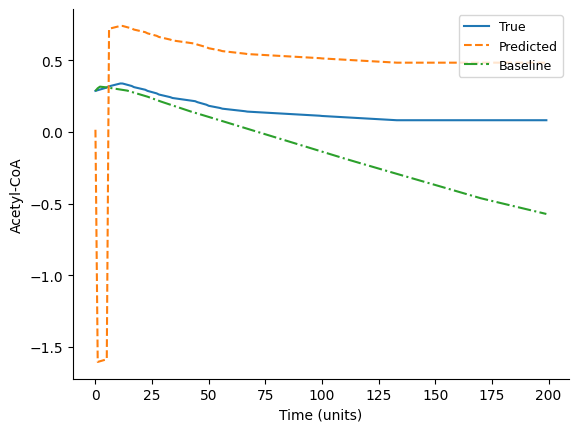

1


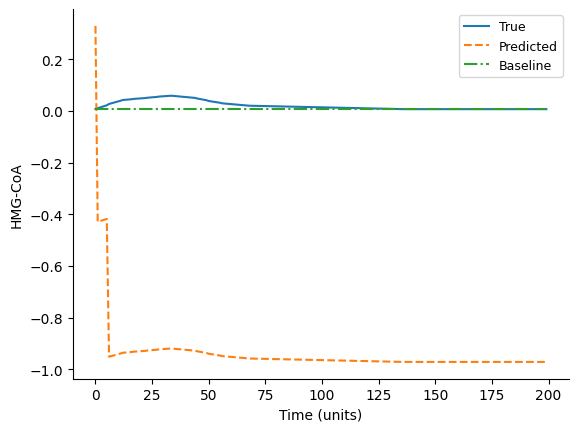

2


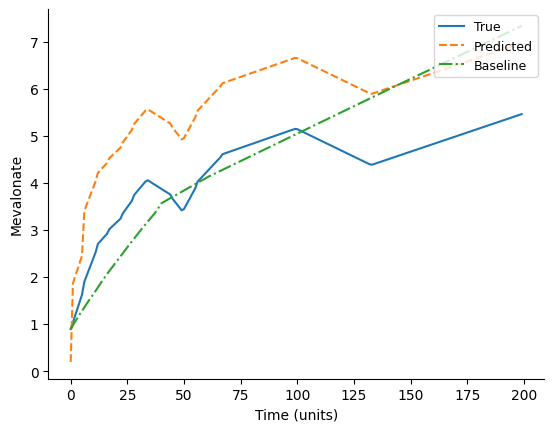

3


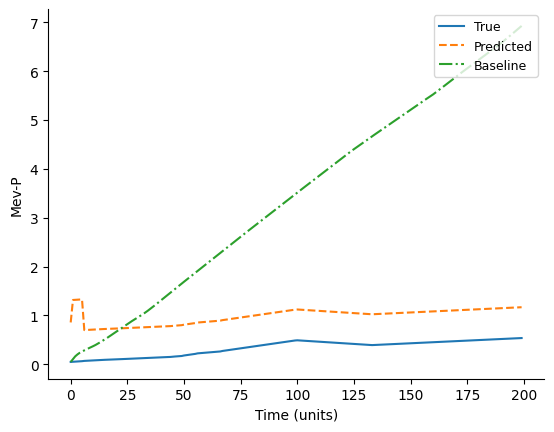

4


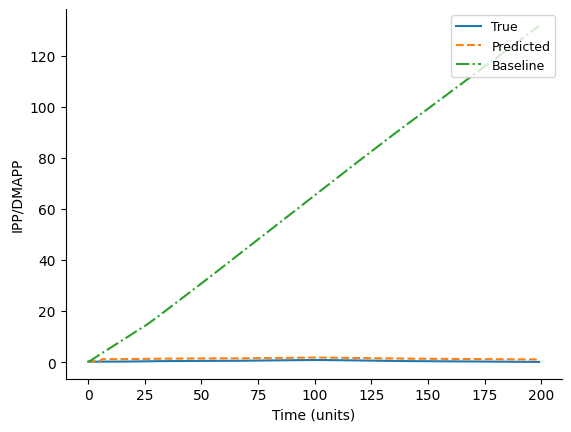

5


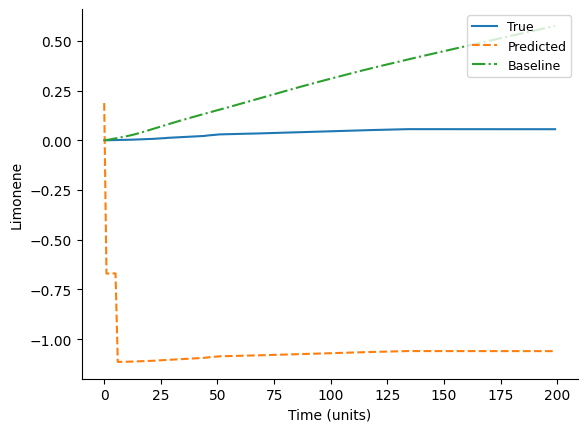

6


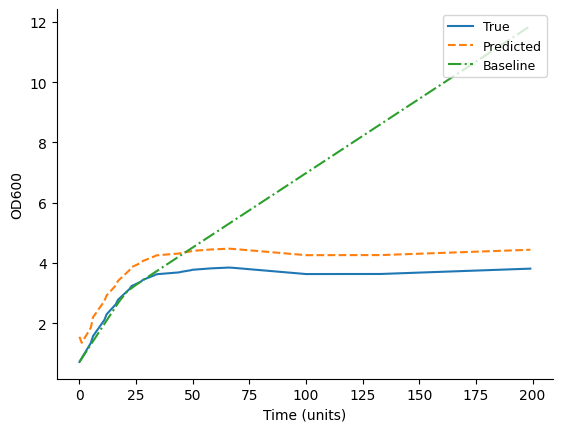

7


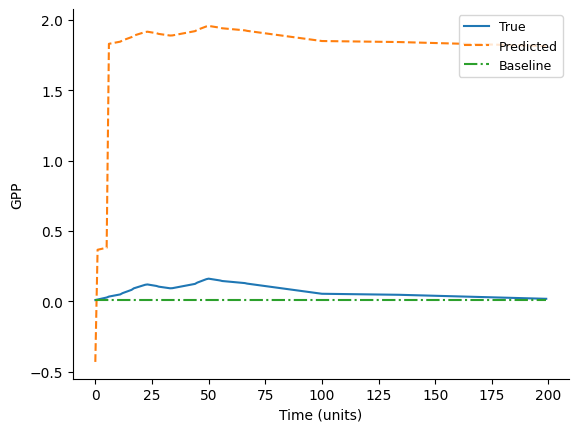

8


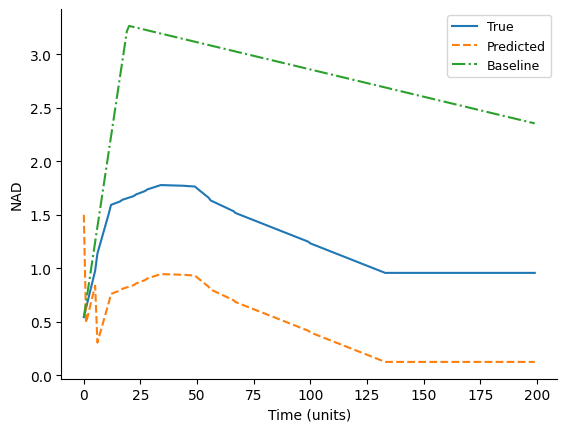

9


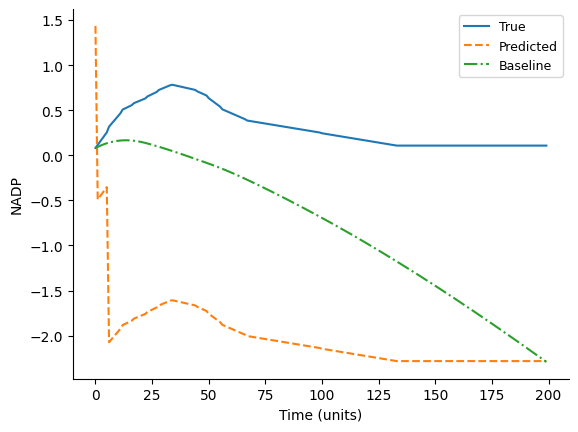

10


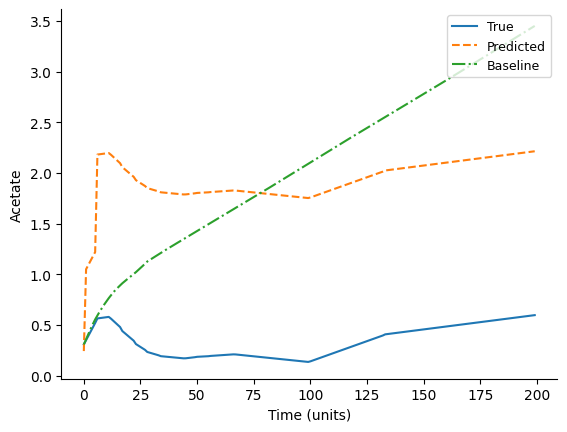

11


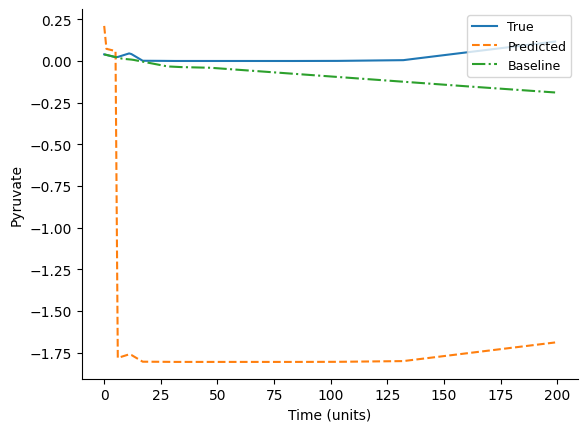

12


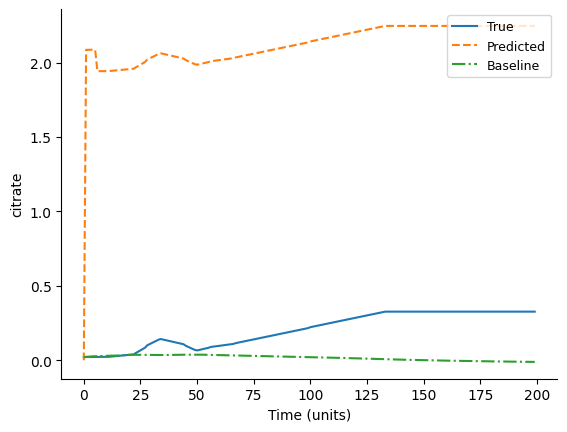

In [79]:
for metabolite in range(len(limonene_df['states'].columns)):
  print(metabolite)
  # Create the figure
  plt.figure()

  # Plot the true and predicted values
  plt.plot(L2[:,metabolite].cpu(), label='True', linewidth=1.5)
  plt.plot(y_pred[:, metabolite], label='Predicted', linewidth=1.5, linestyle='--')
  plt.plot(trajectory_df[metabolites[metabolite]], label='Baseline', linewidth=1.5, linestyle='-.')

  # Format the axes
  ax = plt.gca()
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_linewidth(0.8)
  ax.spines['bottom'].set_linewidth(0.8)

  # Set axis labels
  ax.set_xlabel("Time (units)", fontsize=10)  # Adjust "Time (units)" to the relevant label
  ax.set_ylabel(f"{metabolites[metabolite]}", fontsize=10)        # Adjust "Value" to the relevant label

  # Add legend
  plt.legend(loc='upper right', fontsize=9)

  # Display the plot
  plt.show()

# Learn Isopentenol Dynamics

## Baseline

In [40]:
columns = pd.read_csv("/content/drive/MyDrive/KineticLearning/data/isopentenol_data.csv").columns


# List of proteins (controls)
controls_list = [
    "AtoB", "GPPS", "HMGR", "HMGS", "Idi",
    "Limonene Synthase", "MK", "NudB", "PMD", "PMK"
]

# Separate into controls and states
controls = [column for column in columns if column in controls_list]
# remove strain, and hour columns
states = [column for column in columns if column not in controls][2:]

# Print the results
print("Controls:", controls)
print("States:", states)



Controls: ['AtoB', 'GPPS', 'HMGR', 'HMGS', 'Idi', 'Limonene Synthase', 'MK', 'NudB', 'PMD', 'PMK']
States: ['Acetyl-CoA', 'HMG-CoA', 'Mevalonate', 'Mev-P', 'IPP/DMAPP', 'Limonene', 'OD600', 'GPP', 'NAD', 'NADP', 'Acetate', 'Pyruvate', 'citrate', 'Isopentenol']


In [41]:
iso_df = read_timeseries_data('/content/drive/MyDrive/KineticLearning/data/isopentenol_data.csv',states,controls,time='Hour',strain='Strain',augment=200)

In [42]:
# drop either the limonene or isopentenol pathway. In other cases, the values will be imputed when generating the new 200 length time series
iso_df = iso_df.dropna(axis=1, how='all')

In [43]:
iso_df.index = iso_df.index.droplevel(0)


In [44]:
iso_start_time_learn_baseline = time.time()
# in paper : 12 generations, pop 30
model = learn_dynamics(iso_df.loc[['I1','I3']],generations=12,population_size=30,verbose=True)
iso_end_time_learn_baseline = time.time()
iso_time_to_learn_baseline = iso_end_time_learn_baseline - iso_start_time_learn_baseline
print(f"Iso baseline train time : {iso_time_to_learn_baseline}")

Fitting model for derivative 'Acetyl-CoA': X shape (400, 23), y shape (400,)


Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.00011643615165597641

Generation 2 - Current best internal CV score: -9.529198176194958e-05

Generation 3 - Current best internal CV score: -9.529198176194958e-05

Generation 4 - Current best internal CV score: -9.529198176194958e-05

Generation 5 - Current best internal CV score: -8.979297767934864e-05

Generation 6 - Current best internal CV score: -8.979297767934864e-05

Generation 7 - Current best internal CV score: -8.979297767934864e-05

Generation 8 - Current best internal CV score: -8.979297767934864e-05

Generation 9 - Current best internal CV score: -8.408153098241004e-05

Generation 10 - Current best internal CV score: -8.408153098241004e-05

Generation 11 - Current best internal CV score: -8.408153098241004e-05

Generation 12 - Current best internal CV score: -8.408153098241004e-05

Best pipeline: XGBRegressor(RidgeCV(input_matrix), learning_rate=0.1, max_depth=5, min_child_weight=16, n_estimators=100, n_jobs=1, objective=r

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -7.426375701596628e-06

Generation 2 - Current best internal CV score: -7.426375701596628e-06

Generation 3 - Current best internal CV score: -7.426375701596628e-06

Generation 4 - Current best internal CV score: -7.426375701596628e-06

Generation 5 - Current best internal CV score: -7.426375701596628e-06

Generation 6 - Current best internal CV score: -7.426375701596628e-06

Generation 7 - Current best internal CV score: -7.40215329169801e-06

Generation 8 - Current best internal CV score: -7.363166398118866e-06

Generation 9 - Current best internal CV score: -7.363166398118866e-06

Generation 10 - Current best internal CV score: -7.363166398118866e-06

Generation 11 - Current best internal CV score: -7.3531553987413465e-06

Generation 12 - Current best internal CV score: -7.339816230260948e-06

Best pipeline: DecisionTreeRegressor(StandardScaler(VarianceThreshold(input_matrix, threshold=0.005)), max_depth=5, min_samples_leaf=13, min_sam

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.0020918539025174686

Generation 2 - Current best internal CV score: -0.002087086231283495

Generation 3 - Current best internal CV score: -0.001901416263293911

Generation 4 - Current best internal CV score: -0.001901416263293911

Generation 5 - Current best internal CV score: -0.001901416263293911

Generation 6 - Current best internal CV score: -0.001901416263293911

Generation 7 - Current best internal CV score: -0.001901416263293911

Generation 8 - Current best internal CV score: -0.0018943902901778446

Generation 9 - Current best internal CV score: -0.0018290538386960971

Generation 10 - Current best internal CV score: -0.0018290538386960971

Generation 11 - Current best internal CV score: -0.0018290538386960971

Generation 12 - Current best internal CV score: -0.0018290538386960971

Best pipeline: KNeighborsRegressor(ZeroCount(MaxAbsScaler(input_matrix)), n_neighbors=33, p=2, weights=distance)
Best pipeline for 'Mevalonate': Pipel

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.006523100799457534

Generation 2 - Current best internal CV score: -0.006523100799457534

Generation 3 - Current best internal CV score: -0.006523100799457534

Generation 4 - Current best internal CV score: -0.006523100799457534

Generation 5 - Current best internal CV score: -0.006523100799457534

Generation 6 - Current best internal CV score: -0.006523100799457534

Generation 7 - Current best internal CV score: -0.006523100799457534

Generation 8 - Current best internal CV score: -0.006523100799457534

Generation 9 - Current best internal CV score: -0.006523100799457534

Generation 10 - Current best internal CV score: -0.006523100799457534

Generation 11 - Current best internal CV score: -0.006523100799457534

Generation 12 - Current best internal CV score: -0.006523100799457534

Best pipeline: DecisionTreeRegressor(ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.5, min_samples_leaf=7, min_samples_split=17, n_estimat

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.5266842707590786

Generation 2 - Current best internal CV score: -0.5171689499477821

Generation 3 - Current best internal CV score: -0.5171689499477821

Generation 4 - Current best internal CV score: -0.5171689499477821

Generation 5 - Current best internal CV score: -0.4988493674095905

Generation 6 - Current best internal CV score: -0.49034976568996

Generation 7 - Current best internal CV score: -0.49034976568996

Generation 8 - Current best internal CV score: -0.49034976568996

Generation 9 - Current best internal CV score: -0.49034976568996

Generation 10 - Current best internal CV score: -0.49034976568996

Generation 11 - Current best internal CV score: -0.49034976568996

Generation 12 - Current best internal CV score: -0.49034976568996

Best pipeline: RandomForestRegressor(StandardScaler(input_matrix), bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=10, min_samples_split=19, n_estimators=100)
Best pipeline fo

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.0021536397149600527

Generation 2 - Current best internal CV score: -0.002130776951751767

Generation 3 - Current best internal CV score: -0.002130776951751767

Generation 4 - Current best internal CV score: -0.002130776951751767

Generation 5 - Current best internal CV score: -0.0020522010633316243

Generation 6 - Current best internal CV score: -0.0020522010633316243

Generation 7 - Current best internal CV score: -0.0020522010633316243

Generation 8 - Current best internal CV score: -0.0020522010633316243

Generation 9 - Current best internal CV score: -0.0020522010633316243

Generation 10 - Current best internal CV score: -0.0020522010633316243

Generation 11 - Current best internal CV score: -0.0020522010633316243

Generation 12 - Current best internal CV score: -0.0020522010633316243

Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=7, p=1, weights=distance)
Best pipeline for 'OD600': Pipeline(steps=[('kneighborsregre

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -5.1167389394118136e-08

Generation 2 - Current best internal CV score: -4.5510051468378596e-08

Generation 3 - Current best internal CV score: -4.5510051468378596e-08

Generation 4 - Current best internal CV score: -4.5510051468378596e-08

Generation 5 - Current best internal CV score: -4.5510051468378596e-08

Generation 6 - Current best internal CV score: -4.5510051468378596e-08

Generation 7 - Current best internal CV score: -4.5510051468378596e-08

Generation 8 - Current best internal CV score: -4.5510051468378596e-08

Generation 9 - Current best internal CV score: -4.5510051468378596e-08

Generation 10 - Current best internal CV score: -4.5510051468378596e-08

Generation 11 - Current best internal CV score: -4.5510051468378596e-08

Generation 12 - Current best internal CV score: -4.475841315204896e-08

Best pipeline: XGBRegressor(RidgeCV(StandardScaler(input_matrix)), learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.0021863688806585354

Generation 2 - Current best internal CV score: -0.0012345493805733913

Generation 3 - Current best internal CV score: -0.0012345493805733913

Generation 4 - Current best internal CV score: -0.0012345493805733913

Generation 5 - Current best internal CV score: -0.0012345493805733913

Generation 6 - Current best internal CV score: -0.001217358796274947

Generation 7 - Current best internal CV score: -0.001217358796274947

Generation 8 - Current best internal CV score: -0.001217358796274947

Generation 9 - Current best internal CV score: -0.001217358796274947

Generation 10 - Current best internal CV score: -0.001217358796274947

Generation 11 - Current best internal CV score: -0.001217358796274947

Generation 12 - Current best internal CV score: -0.0011720166895481036

Best pipeline: KNeighborsRegressor(MaxAbsScaler(input_matrix), n_neighbors=2, p=1, weights=distance)
Best pipeline for 'NAD': Pipeline(steps=[('maxabs

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2.713861387740673e-05

Generation 2 - Current best internal CV score: -2.6366142718044357e-05

Generation 3 - Current best internal CV score: -2.519189866384594e-05

Generation 4 - Current best internal CV score: -2.4500517755913114e-05

Generation 5 - Current best internal CV score: -2.235223938078192e-05

Generation 6 - Current best internal CV score: -2.2282826877359167e-05

Generation 7 - Current best internal CV score: -2.2282826877359167e-05

Generation 8 - Current best internal CV score: -2.2282826877359167e-05

Generation 9 - Current best internal CV score: -2.1885830929048232e-05

Generation 10 - Current best internal CV score: -1.998335767563517e-05

Generation 11 - Current best internal CV score: -1.998335767563517e-05

Generation 12 - Current best internal CV score: -1.998335767563517e-05

Best pipeline: ExtraTreesRegressor(MinMaxScaler(RidgeCV(MaxAbsScaler(KNeighborsRegressor(StandardScaler(input_matrix), n_neighbors=15, p=1

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.00044848207145900976

Generation 2 - Current best internal CV score: -0.0004242600552689219

Generation 3 - Current best internal CV score: -0.00040332501079095993

Generation 4 - Current best internal CV score: -0.00040332501079095993

Generation 5 - Current best internal CV score: -0.00029854346083928065

Generation 6 - Current best internal CV score: -0.00029854346083928065

Generation 7 - Current best internal CV score: -0.00029854346083928065

Generation 8 - Current best internal CV score: -0.00029854346083928065

Generation 9 - Current best internal CV score: -0.00029854346083928065

Generation 10 - Current best internal CV score: -0.00029854346083928065

Generation 11 - Current best internal CV score: -0.00029854346083928065

Generation 12 - Current best internal CV score: -0.00029854346083928065

Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=square, n_estimators=100)
Best pipeline for 'Acetate': Pipelin

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -4.4542264398774326e-05

Generation 2 - Current best internal CV score: -4.4542264398774326e-05

Generation 3 - Current best internal CV score: -4.067520415263565e-05

Generation 4 - Current best internal CV score: -4.067520415263565e-05

Generation 5 - Current best internal CV score: -4.067520415263565e-05

Generation 6 - Current best internal CV score: -4.067520415263565e-05

Generation 7 - Current best internal CV score: -4.067520415263565e-05

Generation 8 - Current best internal CV score: -4.067520415263565e-05

Generation 9 - Current best internal CV score: -4.067520415263565e-05

Generation 10 - Current best internal CV score: -4.0145350900234545e-05

Generation 11 - Current best internal CV score: -4.0145350900234545e-05

Generation 12 - Current best internal CV score: -4.0145350900234545e-05

Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=9, min_samples_leaf=8, min_samples_split=18)
Best pipeline for 'Pyruvate': Pip

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1.3152128686058507e-05

Generation 2 - Current best internal CV score: -1.3152128686058507e-05

Generation 3 - Current best internal CV score: -1.3152128686058507e-05

Generation 4 - Current best internal CV score: -1.3152128686058507e-05

Generation 5 - Current best internal CV score: -1.071116703257085e-05

Generation 6 - Current best internal CV score: -1.0632789248453348e-05

Generation 7 - Current best internal CV score: -1.0452965794934782e-05

Generation 8 - Current best internal CV score: -1.0452965794934782e-05

Generation 9 - Current best internal CV score: -1.0452965794934782e-05

Generation 10 - Current best internal CV score: -9.132658723138415e-06

Generation 11 - Current best internal CV score: -9.032873529845903e-06

Generation 12 - Current best internal CV score: -9.032873529845903e-06

Best pipeline: GradientBoostingRegressor(RidgeCV(RobustScaler(input_matrix)), alpha=0.9, learning_rate=0.01, loss=huber, max_depth=8, ma

Optimization Progress:   0%|          | 0/390 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.00010999751620424216

Generation 2 - Current best internal CV score: -0.00010999751620424216

Generation 3 - Current best internal CV score: -0.000102548514176518

Generation 4 - Current best internal CV score: -9.322681411069462e-05

Generation 5 - Current best internal CV score: -9.322681411069462e-05

Generation 6 - Current best internal CV score: -9.322681411069462e-05

Generation 7 - Current best internal CV score: -9.322681411069462e-05

Generation 8 - Current best internal CV score: -9.322681411069462e-05

Generation 9 - Current best internal CV score: -9.322681411069462e-05

Generation 10 - Current best internal CV score: -7.532743495131778e-05

Generation 11 - Current best internal CV score: -7.532743495131778e-05

Generation 12 - Current best internal CV score: -7.532743495131778e-05

Best pipeline: ExtraTreesRegressor(LinearSVR(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), C=0.5, dua

,model
Acetyl-CoA,"(StackingEstimator(estimator=RidgeCV()), XGBRe..."
HMG-CoA,"(VarianceThreshold(threshold=0.005), StandardS..."
Mevalonate,"(MaxAbsScaler(), ZeroCount(), KNeighborsRegres..."
Mev-P,(StackingEstimator(estimator=ExtraTreesRegress...
IPP/DMAPP,"(StandardScaler(), (DecisionTreeRegressor(max_..."
OD600,"(KNeighborsRegressor(n_neighbors=7, p=1, weigh..."
GPP,"(StandardScaler(), StackingEstimator(estimator..."
NAD,"(MaxAbsScaler(), KNeighborsRegressor(n_neighbo..."
NADP,"(StandardScaler(), StackingEstimator(estimator..."
Acetate,"((DecisionTreeRegressor(max_depth=3, random_st..."


Iso baseline train time : 3707.5785772800446


In [45]:
print(f"Iso baseline train time : {iso_time_to_learn_baseline}")

Iso baseline train time : 3707.5785772800446


In [ ]:
# Save the trained model to disk
with open("iso_baseline_trained_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)
print("Model saved to 'iso_baseline_trained_model.pkl'.")

In [ ]:
# load the model
with open("iso_baseline_trained_model.pkl", "rb") as model_file:
    model = pickle.load(model_file)

In [46]:
# Test with unseen strain
strain_df = iso_df.loc['I2']
start = time.time()
trajectory_df = simulate_dynamics(model,strain_df,verbose=True)
end = time.time()
print(f"Time to predict : {end-start}")

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/KineticLearning/notebooks/KineticLearning.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = self.model_df.apply(lambda model: model[0].predict(X.reshape(1,-1)),axis=1).values.reshape(-1,)
/content/drive/MyDrive/KineticLearning/notebooks/KineticLearning.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = self.model_df.apply(lambda model: model[0].predict(X.reshape(1,-1)),axis=1).values.reshape(-1,)
/content/drive/MyDrive/KineticLearning/notebooks/KineticLearning.py:260: FutureWarning: Series.__getitem__ treating keys as positions i

Time to predict : 242.48914766311646


/content/drive/MyDrive/KineticLearning/notebooks/KineticLearning.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = self.model_df.apply(lambda model: model[0].predict(X.reshape(1,-1)),axis=1).values.reshape(-1,)
/content/drive/MyDrive/KineticLearning/notebooks/KineticLearning.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = self.model_df.apply(lambda model: model[0].predict(X.reshape(1,-1)),axis=1).values.reshape(-1,)
/content/drive/MyDrive/KineticLearning/notebooks/KineticLearning.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

In [47]:
print(f"Time to predict : {end-start}")

Time to predict : 242.48914766311646


In [ ]:
# Save trajectory_df to disk as a CSV file
trajectory_df.to_csv("iso_baseline_trajectory_df.csv", index=False)
print("Trajectory data saved to 'trajectory_df.csv'.")

Trajectory data saved to 'trajectory_df.csv'.


## NODE model

In [48]:
# Single strain
#inputs = limonene_df.loc['L1'][["states","controls"]].values
# 2 strains
inputs = iso_df.loc[['I1','I3']][["states","controls"]].values
# Prepare dataset
X_train = torch.Tensor(inputs).to(device)  # Input data: shape (n_points, 2)
y_train = torch.Tensor(inputs).to(device) # Target data: shape (n_points, 1)


# Create TensorDataset and DataLoader
train_dataset = data.TensorDataset(X_train, y_train)
train_loader = data.DataLoader(train_dataset, batch_size=len(inputs)//2, shuffle=False)

In [49]:
class NeuralODEFunc(nn.Module):
    def __init__(self):
        super(NeuralODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(23, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10,10),
            nn.Tanh(),
            nn.Linear(10, 23)  # Output same size as input features
        )

        # initialize weights
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
        return self.net(x)  # Return the time derivative dx/dt

class NeuralODE(nn.Module):
    def __init__(self, func, t_span):
        super(NeuralODE, self).__init__()
        self.func = func
        self.t_span = t_span

    def forward(self, x):
        # Solve the ODE for the given input x
        #print(x[0].shape)
        # NOTE -- Error propagates massively if you predict from x[t=0] --> x[t_n ]
        # and try to train on that
        out = odeint(self.func, x, self.t_span, method='dopri8')
        #print(out.shape)
        return out[-1]  # Return the final state at the last time point

    def all_trajectores(self,x):
        out = odeint(self.func, x, self.t_span, method='dopri8')
        #print(out.shape)
        return out  # Return the final state at the last time point

    def predict(self,x):
        out = odeint(self.func,x[0],self.t_span, method='dopri8')
        #print(out.shape)
        return out

In [50]:
# Define time span for solving the ODE
t_span = torch.linspace(0, 72, 200).to(device)  # Time span for integration
# Define loss function and optimizer
criterion = nn.MSELoss()
pen_loss = lambda x : min(0.0,x)
pen_loss = np.vectorize(pen_loss)
iso_training_times = {}
# Training loop
epochs = 300
penalty_weights = [0.01,1,1e3]
for penalty_weight in penalty_weights:
    # Instantiate the ODE function and model
    func = NeuralODEFunc()
    model = NeuralODE(func, t_span).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    iso_start_time_NODE_training = time.time()
    print("##############")
    print(f"Training with penalty {penalty_weight}")
    print("Starting ADAM...")
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            y_pred = model(batch_X)  # Predict y using the Neural ODE
            #l += λ .* sum(abs2, min.(0, ŷ_reg))
            #print(f"y_pred : {y_pred.shape}, y : {batch_y.shape}")
            loss = criterion(y_pred, batch_y)  # Compute loss
            # penalize the model for predicting values that are negative
            loss_neg = pen_loss(y_pred.detach().cpu().numpy())
            #print(loss.shape)
            loss += penalty_weight*np.mean(np.square(loss_neg))
            #print(y_pred.shape)
            #loss += sum(min(0,))
            loss.backward()
            optimizer.step()
        #if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    # Stage 2: BFGS optimization
    def closure():
        bfgs_optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss_neg = pen_loss(y_pred.cpu().detach().numpy())
        loss += penalty_weight * np.mean(np.square(loss_neg))
        loss.backward()
        print(f"Loss: {loss.item():.4f}")
        return loss
    print("--------------")
    print("Starting BFGS optimization..")
    bfgs_optimizer = LBFGS(model.parameters(), lr=1e-4, max_iter=1000, tolerance_grad=1e-6, tolerance_change=1e-6)
    for batch_X, batch_y in train_loader:
        bfgs_optimizer.step(closure)
    iso_end_time_NODE_training = time.time()
    iso_time_to_learn_NODE = iso_end_time_NODE_training - iso_start_time_NODE_training
    iso_training_times[penalty_weight] = iso_time_to_learn_NODE
    print("BFGS optimization completed.")
    # Save the trained model
    model_path = f"{penalty_weight}_iso_trained_neural_ode_model.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to '{model_path}'.")

##############
Training with penalty 0.01
Starting ADAM...
Epoch 1, Loss: 4.3041
Epoch 2, Loss: 3.9354
Epoch 3, Loss: 3.7308
Epoch 4, Loss: 3.5492
Epoch 5, Loss: 3.3480
Epoch 6, Loss: 3.1694
Epoch 7, Loss: 4.0282
Epoch 8, Loss: 2.8739
Epoch 9, Loss: 2.6892
Epoch 10, Loss: 2.5434
Epoch 11, Loss: 3.1289
Epoch 12, Loss: 2.2687
Epoch 13, Loss: 2.2431
Epoch 14, Loss: 2.6814
Epoch 15, Loss: 2.0141
Epoch 16, Loss: 2.0409
Epoch 17, Loss: 1.8245
Epoch 18, Loss: 1.6345
Epoch 19, Loss: 1.6511
Epoch 20, Loss: 1.4691
Epoch 21, Loss: 1.3903
Epoch 22, Loss: 1.3279
Epoch 23, Loss: 1.2552
Epoch 24, Loss: 1.2085
Epoch 25, Loss: 1.3343
Epoch 26, Loss: 1.1756
Epoch 27, Loss: 1.0350
Epoch 28, Loss: 2.0591
Epoch 29, Loss: 1.0035
Epoch 30, Loss: 0.9266
Epoch 31, Loss: 1.3330
Epoch 32, Loss: 0.8714
Epoch 33, Loss: 0.8329
Epoch 34, Loss: 0.8911
Epoch 35, Loss: 1.2965
Epoch 36, Loss: 0.6865
Epoch 37, Loss: 0.6580
Epoch 38, Loss: 0.6406
Epoch 39, Loss: 0.9787
Epoch 40, Loss: 1.9082
Epoch 41, Loss: 0.5644
Epoch 4

In [54]:
sum([value/60 for key,value in iso_training_times.items()])/3

5.397621124320559

In [55]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

metabolites = list(iso_df['states'].columns)
# load the iso_baseline_trajectory_df.csv
trajectory_df = pd.read_csv("iso_baseline_trajectory_df.csv")

# Model paths
model_paths = [
    "0.01_iso_trained_neural_ode_model.pth",
    "1_iso_trained_neural_ode_model.pth",
    "1000.0_iso_trained_neural_ode_model.pth"
]

# Test data
I2 = torch.Tensor(iso_df.loc['I2'][["states","controls"]].values)

# Evaluate all models
results = {}
for model_path in model_paths:
    model_name = model_path.split('_')[0]  # Extract the parameter value
    start = time.time()
    results[model_name] = evaluate_model(model_path, I2, metabolites, device)
    end = time.time()
    print(f"eval time : {model_name}, {end-start}")

# Calculate RMSE for baseline using trajectory_df
baseline_rmse = {}
for metabolite in metabolites:
    baseline_values = trajectory_df[metabolite].values
    true_values = I2[:, metabolites.index(metabolite)].cpu().numpy()
    rmse = np.sqrt(mean_squared_error(true_values, baseline_values))
    baseline_rmse[metabolite] = rmse

# Add baseline to results
results['baseline'] = baseline_rmse

# Create DataFrame
results_df = pd.DataFrame(results).round(4)

# Add mean RMSE row
results_df.loc['Mean RMSE'] = results_df.mean()

# Sort columns for better comparison (keeping baseline as last column)
model_cols = sorted([col for col in results_df.columns if col != 'baseline'])
results_df = results_df[model_cols + ['baseline']]

print("Model Comparison - RMSE values:")
print(results_df)

# Save results to CSV
results_df.to_csv('iso_model_comparison_results.csv')

# Also calculate the percentage improvement over baseline
for col in model_cols:
    results_df[f'{col}_vs_baseline'] = ((results_df['baseline'] - results_df[col]) / results_df['baseline'] * 100).round(2)

print("\nPercentage improvement over baseline (%):")
print(results_df[[col for col in results_df.columns if '_vs_baseline' in col]])

<ipython-input-39-7d99f595e750>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


eval time : 0.01, 0.28876543045043945
eval time : 1, 0.15291690826416016


<ipython-input-39-7d99f595e750>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
<ipython-input-39-7d99f595e750>:11: FutureWar

eval time : 1000.0, 0.25957751274108887
Model Comparison - RMSE values:
                 0.01         1    1000.0    baseline
Acetyl-CoA   0.312700  0.088500  0.508100    9.024300
HMG-CoA      1.196300  0.001900  0.467800    0.077500
Mevalonate   1.264900  0.065500  0.537000    2.551900
Mev-P        0.837100  0.047500  0.742700  126.193700
IPP/DMAPP    0.438300  0.074600  0.240200   33.771200
OD600        1.617500  0.026400  0.411800    2.129700
GPP          1.130100  0.050000  0.517700    0.002200
NAD          0.667300  0.036600  0.289100    1.963400
NADP         0.383400  0.026100  0.302300    0.239800
Acetate      3.627200  0.017700  0.649000    0.447900
Pyruvate     0.501000  0.061000  0.152900    0.063900
citrate      0.642400  0.052600  0.479100    0.291100
Isopentenol  1.483500  0.014100  1.313900    0.317500
Mean RMSE    1.084746  0.043269  0.508585   13.621085

Percentage improvement over baseline (%):
             0.01_vs_baseline  1_vs_baseline  1000.0_vs_baseline
Acetyl-CoA

In [57]:
# load and run inference on trained models
func = NeuralODEFunc()
model = NeuralODE(func, t_span).to(device)
t_span = torch.linspace(0, 72, 200).to(device)
# Load the saved model (replace '0.1_lim_trained_neural_ode_model.pth' with your actual model path)
model_path = "1_iso_trained_neural_ode_model.pth"
model = NeuralODE(func, t_span).to(device)  # Assuming t_span is already defined
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

<ipython-input-57-08be19036090>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


NeuralODE(
  (func): NeuralODEFunc(
    (net): Sequential(
      (0): Linear(in_features=23, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Tanh()
      (4): Linear(in_features=10, out_features=10, bias=True)
      (5): Tanh()
      (6): Linear(in_features=10, out_features=23, bias=True)
    )
  )
)

In [58]:
# Test on unseen strain
I2 = torch.Tensor(iso_df.loc['I2'][["states","controls"]].values)

# # scale the state data between the two strains
# # Extract the first 13 columns (features to normalize)
# features_to_normalize = I2[:, :13]

# # Min-max normalization
# min_vals = features_to_normalize.min(dim=0, keepdim=True).values  # Minimum of each feature
# max_vals = features_to_normalize.max(dim=0, keepdim=True).values     # Std for each feature

# # Normalize these features
# normalized_features = (features_to_normalize - min_vals) / (max_vals - min_vals + np.finfo(float).eps)

# # Keep the remaining columns unchanged
# remaining_features = I2[:, 13:]

# # Recombine the normalized and unnormalized features
# I2_scaled = torch.cat([normalized_features, remaining_features], dim=1).to(device)

# Make predictions
with torch.no_grad():
    y_pred = model(I2.to(device))# Predict for the entire training dataset
    y_pred = y_pred.cpu()

In [59]:
#iso_test = trajectory_df['Isopentenol'].values
# # apply min max scaling
# min_val = min(iso_test)
# max_val = max(iso_test)
# iso_test = (iso_test - min_val) / (max_val - min_val)

# scale all y-pred to be between 0 and 1
#min_val = np.min(y_pred.numpy(), axis = 0)
#max_val = np.max(y_pred.numpy(), axis = 0)
#y_pred = (y_pred - min_val) / (max_val - min_val)


0


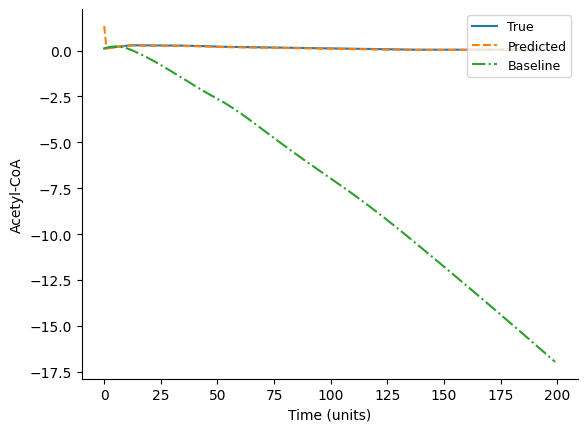

1


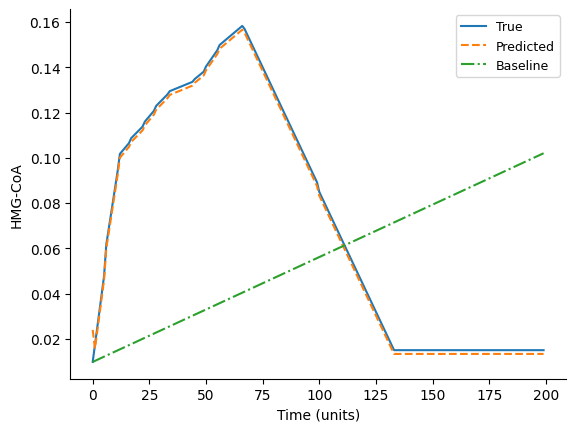

2


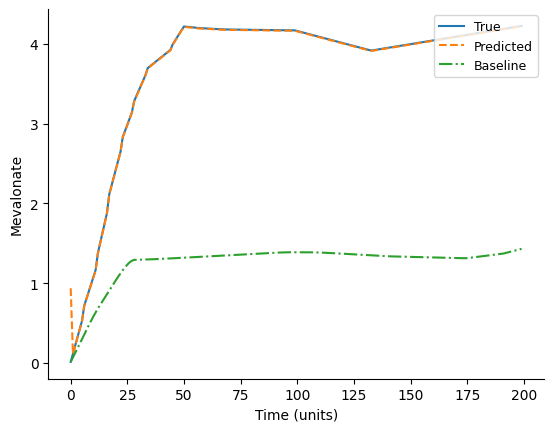

3


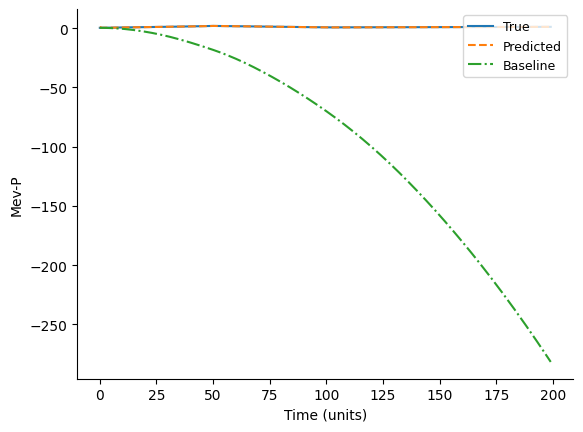

4


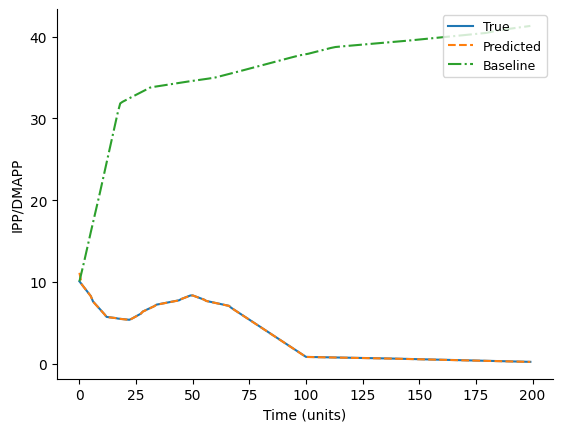

5


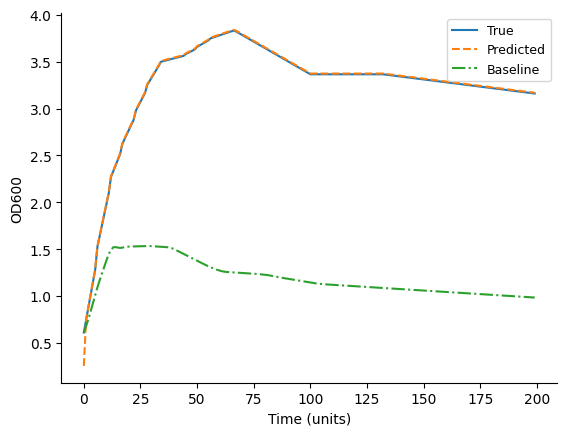

6


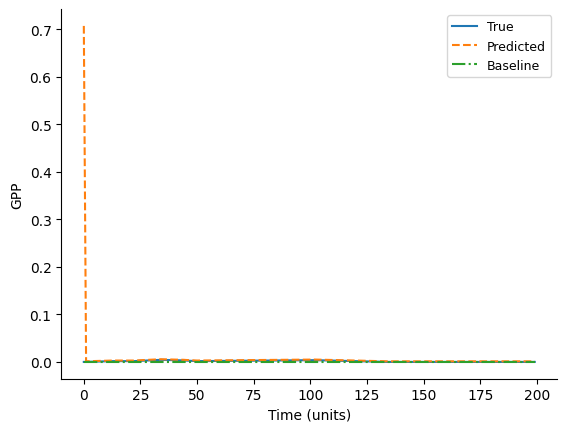

7


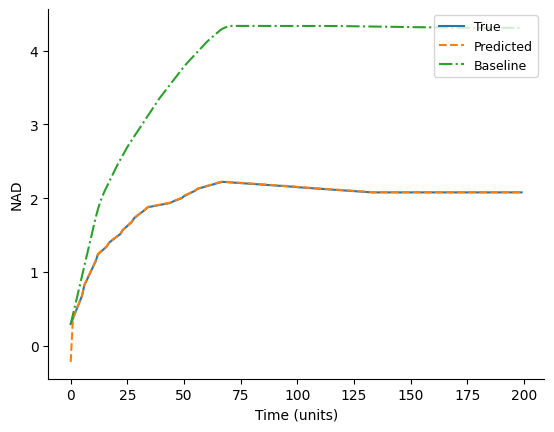

8


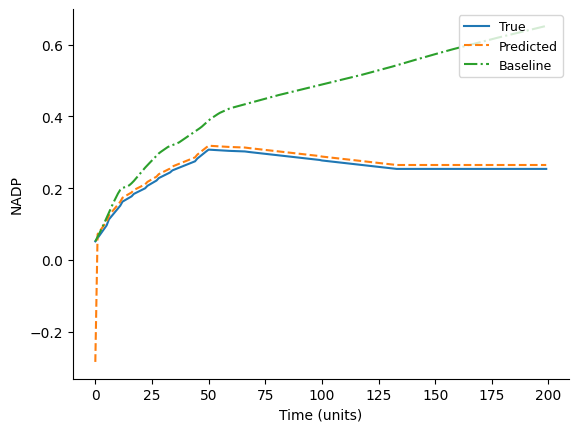

9


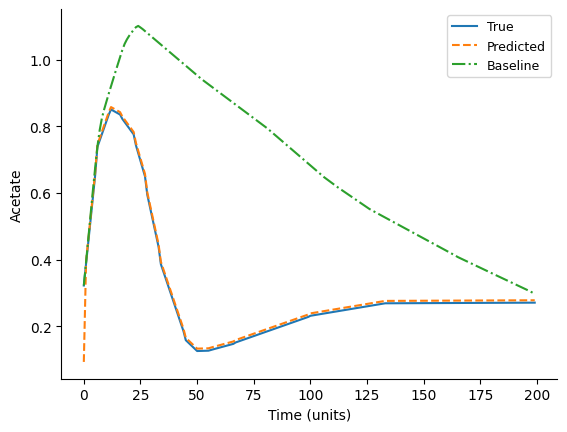

10


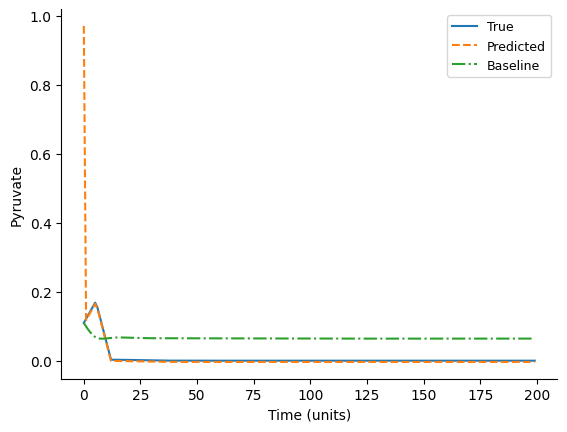

11


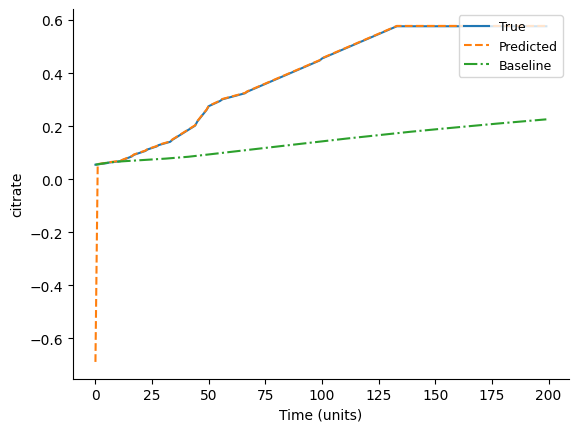

12


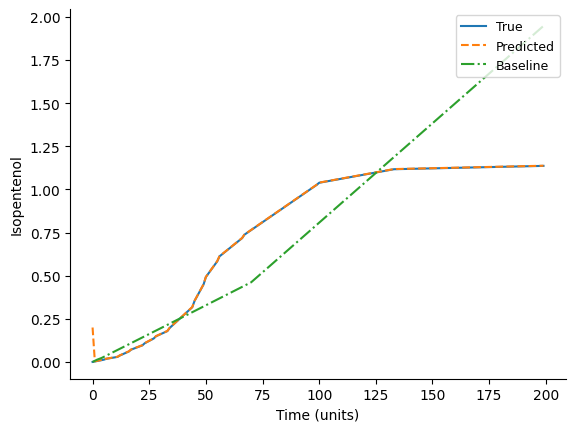

In [60]:
#lim_test = trajectory_d.values
#apply min max scaling
# min_val = min(lim_test)
# max_val = max(lim_test)
# lim_test = (lim_test - min_val) / (max_val - min_val)

#scale all columns in y pred between 0 and 1
# min_val = np.min(y_pred.numpy(), axis = 0)
# max_val = np.max(y_pred.numpy(), axis = 0)
# y_pred = (y_pred - min_val) / (max_val - min_val)

for metabolite in range(len(iso_df['states'].columns)):
  print(metabolite)
  # Create the figure
  plt.figure()

  # Plot the true and predicted values
  plt.plot(I2[:,metabolite].cpu(), label='True', linewidth=1.5)
  plt.plot(y_pred[:, metabolite], label='Predicted', linewidth=1.5, linestyle='--')
  plt.plot(trajectory_df[metabolites[metabolite]], label='Baseline', linewidth=1.5, linestyle='-.')

  # Format the axes
  ax = plt.gca()
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_linewidth(0.8)
  ax.spines['bottom'].set_linewidth(0.8)

  # Set axis labels
  ax.set_xlabel("Time (units)", fontsize=10)  # Adjust "Time (units)" to the relevant label
  ax.set_ylabel(f"{metabolites[metabolite]}", fontsize=10)        # Adjust "Value" to the relevant label

  # Add legend
  plt.legend(loc='upper right', fontsize=9)

  # Display the plot
  plt.show()